# Data: Loading, Cleaning, and Preprocessing

Davis and KIBA datasets, see: https://tdcommons.ai/multi_pred_tasks/dti#davis

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!



DAVIS dataset
Number of drugs:  68
Number of proteins:  379
Number of drug-target pairs:  25772

KIBA dataset
Number of drugs:  2068
Number of proteins:  229
Number of drug-target pairs:  117657

Combined dataset
Number of drugs:  2106
Number of proteins:  428


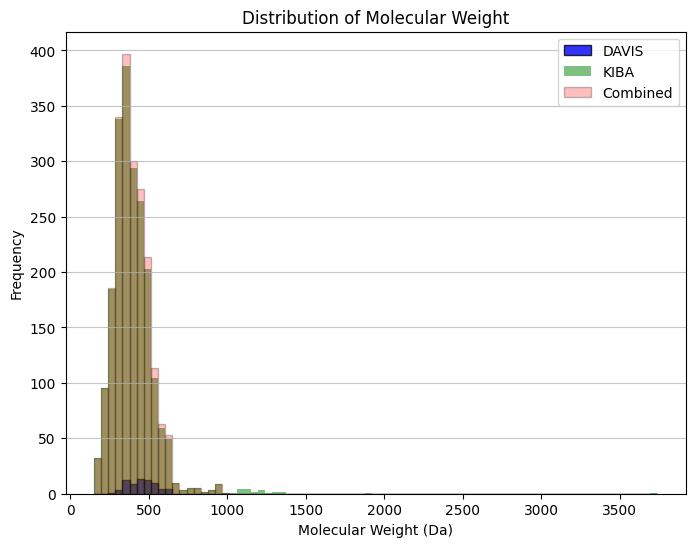

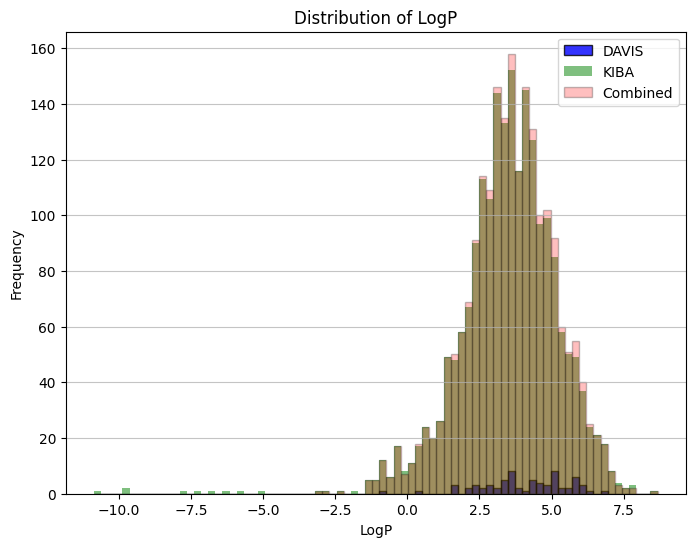

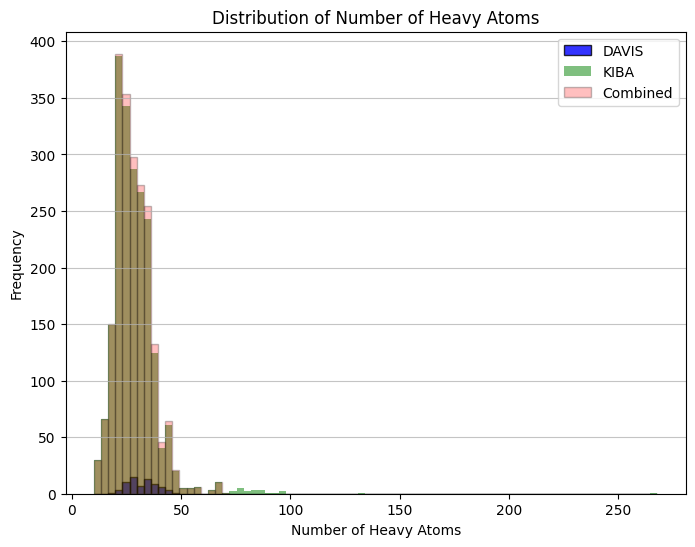

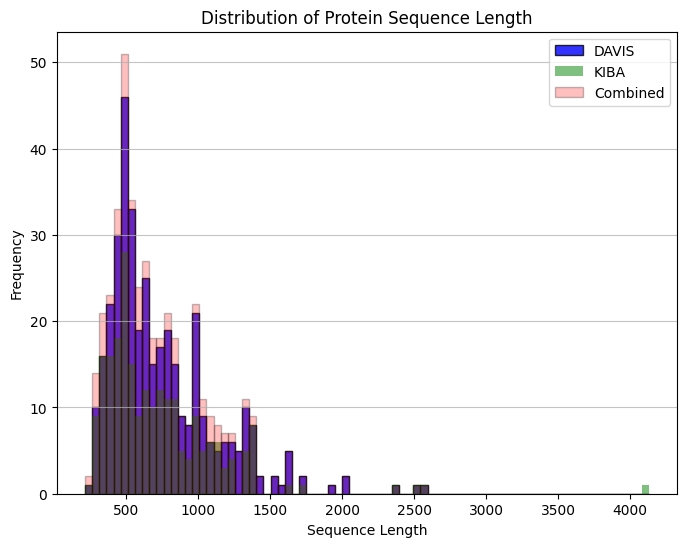

In [1]:
import numpy as np
from tdc.multi_pred import DTI
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt

# Load the datasets
download_davis = DTI(name='DAVIS')
df_davis = download_davis.get_data()
download_kiba = DTI(name='KIBA')
df_kiba = download_kiba.get_data()

# Get unique drugs
drugs_davis = df_davis['Drug'].unique()
drugs_kiba = df_kiba['Drug'].unique()
drugs_combined = np.unique(np.concatenate((drugs_davis, drugs_kiba)))

# Get unique proteins
proteins_davis = df_davis['Target'].unique()
proteins_kiba = df_kiba['Target'].unique()
proteins_combined = np.unique(np.concatenate((proteins_davis, proteins_kiba)))

# Function to compute molecular properties
def compute_properties(smiles_list, MAX_MW=None, MAX_LOGP=None, MAX_HEAVY_ATOMS=None):
    mw_list = []
    logp_list = []
    heavy_atoms_list = []
    result = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            mw = Descriptors.MolWt(mol)
            logp = Descriptors.MolLogP(mol)
            heavy_atoms = Descriptors.HeavyAtomCount(mol)
            if (MAX_MW is None or mw <= MAX_MW) and \
               (MAX_LOGP is None or logp <= MAX_LOGP) and \
               (MAX_HEAVY_ATOMS is None or heavy_atoms <= MAX_HEAVY_ATOMS):
                mw_list.append(mw)
                logp_list.append(logp)
                heavy_atoms_list.append(heavy_atoms)
                result.append(smi)
    return mw_list, logp_list, heavy_atoms_list, result

# Compute properties for both datasets
mw_davis, logp_davis, heavy_atoms_davis, _ = compute_properties(drugs_davis)
mw_kiba, logp_kiba, heavy_atoms_kiba, _ = compute_properties(drugs_kiba)

# cut drugs_combined with the capped properties
mw_combined, logp_combined, heavy_atoms_combined, drugs_filtered = compute_properties(
    drugs_combined, MAX_MW=1000, MAX_LOGP=None, MAX_HEAVY_ATOMS=100)

# Compute proteries of protein amino acid sequences
lens_davis = [len(seq) for seq in proteins_davis]
lens_kiba = [len(seq) for seq in proteins_kiba]
proteins_filtered = [seq for seq in proteins_combined if len(seq) <= 3000] 

if True:
    print("\nDAVIS dataset")
    print("Number of drugs: ", len(df_davis['Drug'].unique()))
    print("Number of proteins: ", len(df_davis['Target'].unique()))
    print("Number of drug-target pairs: ", len(df_davis))
    print("\nKIBA dataset")
    print("Number of drugs: ", len(df_kiba['Drug'].unique()))
    print("Number of proteins: ", len(df_kiba['Target'].unique()))
    print("Number of drug-target pairs: ", len(df_kiba))
    print("\nCombined dataset")
    print("Number of drugs: ", len(drugs_filtered))
    print("Number of proteins: ", len(proteins_filtered))

# Plotting function
def plot_histogram(data1, data2, data3, label1, label2, label3, xlabel, ylabel, title):
    plt.figure(figsize=(8,6))
    bins = np.linspace(
        min(min(data1), min(data2), min(data3)), 
        max(max(data1), max(data2), max(data3)), 
        80
    )
    plt.hist(data1, bins=bins, alpha=0.8, label=label1, color='blue', edgecolor='black')
    plt.hist(data2, bins=bins, alpha=0.5, label=label2, color='green')
    plt.hist(data3, bins=bins, alpha=0.25, label=label3, color='red', edgecolor='black')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Plot Molecular Weight distribution
plot_histogram(
    mw_davis, mw_kiba, mw_combined,
    'DAVIS', 'KIBA', 'Combined',
    'Molecular Weight (Da)', 'Frequency', 'Distribution of Molecular Weight'
)

# Plot LogP distribution
plot_histogram(
    logp_davis, logp_kiba, logp_combined,
    'DAVIS', 'KIBA', 'Combined',
    'LogP', 'Frequency', 'Distribution of LogP'
)

# Plot Number of Heavy Atoms distribution
plot_histogram(
    heavy_atoms_davis, heavy_atoms_kiba, heavy_atoms_combined,
    'DAVIS', 'KIBA', 'Combined',
    'Number of Heavy Atoms', 'Frequency', 'Distribution of Number of Heavy Atoms'
)

# Plot Protein Sequence Length distribution
plot_histogram(
    lens_davis, lens_kiba, [len(seq) for seq in proteins_filtered],
    'DAVIS', 'KIBA', 'Combined',
    'Sequence Length', 'Frequency', 'Distribution of Protein Sequence Length'
)

In [2]:
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split

BATCHE_SIZE = 16

# Split the dataset into train and validation sets
drugs_train, drugs_val = train_test_split(drugs_filtered, test_size=0.2, random_state=42)
proteins_train, proteins_val = train_test_split(proteins_filtered, test_size=0.2, random_state=42)

# Create DataLoader objects for train and validation sets
drugs_train_loader = DataLoader(drugs_train, batch_size=BATCHE_SIZE, shuffle=True)
drugs_val_loader = DataLoader(drugs_val, batch_size=BATCHE_SIZE, shuffle=False)
proteins_train_loader = DataLoader(proteins_train, batch_size=BATCHE_SIZE, shuffle=True)
proteins_val_loader = DataLoader(proteins_val, batch_size=BATCHE_SIZE, shuffle=False)

print("Number of batches & samples for drugs (train): ", len(drugs_train_loader), len(drugs_train_loader.dataset))
print("Number of batches & samples for drugs (val): ", len(drugs_val_loader), len(drugs_val_loader.dataset))
print("Number of batches & samples for proteins (train): ", len(proteins_train_loader), len(proteins_train_loader.dataset))
print("Number of batches & samples for proteins (val): ", len(proteins_val_loader), len(proteins_val_loader.dataset))
drug_lens = [(len(seq)) for seq in drugs_train_loader.dataset]
print("ID of min and max: ", np.argmin(drug_lens), np.argmax(drug_lens))

Number of batches & samples for drugs (train):  106 1684
Number of batches & samples for drugs (val):  27 422
Number of batches & samples for proteins (train):  22 342
Number of batches & samples for proteins (val):  6 86
ID of min and max:  665 1220


We encode molecules through one-hot-encoding of [RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html) features


Example molecule 1220 :  O=C1OC2C3COC(=O)c4cc(O)c(O)c(O)c4-c4c(cc(O)c(O)c4O)C(=O)OC2C(OC(=O)c2cc(O)c(O)c4c2C2C1=CC(=O)C(O)(O)C2(O)O4)C(OC(=O)c1cc(O)c(O)c(O)c1)O3
Number of atoms:  68
Number of bonds:  76


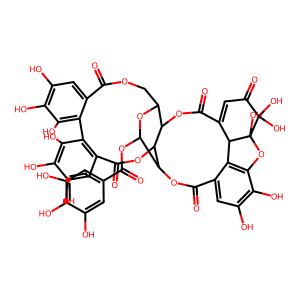

Converting SMILES to torch_geometric Data instance for:  O=C1OC2C3COC(=O)c4cc(O)c(O)c(O)c4-c4c(cc(O)c(O)c4O)C(=O)OC2C(OC(=O)c2cc(O)c(O)c4c2C2C1=CC(=O)C(O)(O)C2(O)O4)C(OC(=O)c1cc(O)c(O)c(O)c1)O3
Number of nodes:  68
Node features:  torch.Size([68, 9]) 
- example: tensor([8, 0, 1, 5, 0, 0, 3, 0, 0]) 
- out of classes:  [119, 9, 11, 12, 9, 5, 8, 2, 2]

Number of edges:  152
Edges have to be represented undirected as a COO tensor
Edge features:  torch.Size([152, 3]) 
- example: tensor([2, 0, 1]) 
- out of classes:  [22, 6, 2]


Data(x=[68, 9], edge_index=[2, 152], edge_attr=[152, 3], smiles='O=C1OC2C3COC(=O)c4cc(O)c(O)c(O)c4-c4c(cc(O)c(O)c4O)C(=O)OC2C(OC(=O)c2cc(O)c(O)c4c2C2C1=CC(=O)C(O)(O)C2(O)O4)C(OC(=O)c1cc(O)c(O)c(O)c1)O3')

In [3]:
from encoding import smiles2pydata

example_index = 1220
print("\nExample molecule", example_index, ': ', drugs_train[example_index])
example_drug = smiles2pydata(drugs_train[example_index], with_hydrogen=False, give_description=True)
for batch in drugs_train_loader:
    example_drug_batch = batch
    break
for batch in proteins_train_loader:
    example_protein_batch = batch
    break

num_node_features = example_drug.x.shape[1]
num_edge_features = example_drug.edge_attr.shape[1]
example_drug

---
---

# Encoding

## Encoding drug-molecules

Molecules in SMILES fromat are embedded through 3 views: MolGraph, Image, SMILES

See
 - https://github.com/BiomedSciAI/biomed-multi-view
 - https://huggingface.co/ibm/biomed.sm.mv-te-84m

In [9]:
from models import DrugBranch

model_drug = DrugBranch(
    embeddings_sizes = [512, 512, 768],
    hidden_dim = 512,
    latent_dim = 1024
)
z, loss_recon, loss_kl = model_drug.forward(example_drug_batch, compute_loss=True)
print("Output shape: ", z.shape)
print("Reconstruction loss: ", loss_recon)
print("KL divergence loss: ", loss_kl)

2024-11-11 14:08:20,337 - root - INFO - pop-os:139505272090368:0:0 - BioMed Multi-view embedding model
2024-11-11 14:08:20,338 - root - INFO - pop-os:139505272090368:0:0 - dim_list [512, 512, 768] of Graph2dModel, ImageModel, TextModel
2024-11-11 14:08:20,347 - root - INFO - pop-os:139505272090368:0:0 - Loading checkpoint from provided path ../data_root/bmfm_model_dir/biomed-smmv-base.pth
2024-11-11 14:08:20,426 - root - INFO - pop-os:139505272090368:0:0 - Loading pretrain checkpoint for SmallMoleculeMultiView Model - _IncompatibleKeys(missing_keys=['aggregator.projections.0.weight', 'aggregator.projections.0.bias', 'aggregator.projections.1.weight', 'aggregator.projections.1.bias', 'aggregator.projections.2.weight', 'aggregator.projections.2.bias', 'aggregator.w_before_mean.0.weight', 'aggregator.w_before_mean.0.bias', 'aggregator.w_before_mean.2.weight', 'aggregator.down_project.weight', 'aggregator.down_project.bias', 'aggregator.shared_task_head.0.weight', 'aggregator.shared_task_h


Number of parameters per component:
SMVV encoder: 81,329,728
Branch up:
- Encodings to Z: 4,470,784
- Z aggregator: 3,023,872
- Aggrigate to Z: 1,577,984
Branch down:
- Z to Aggrigate: 1,052,160
- Aggrigate expander: 2,761,984
- Z to Encodings: 3,354,880

Output shape:  torch.Size([16, 1024])
Reconstruction loss:  tensor(1.3972, grad_fn=<AddBackward0>)
KL divergence loss:  tensor(300.3580, grad_fn=<AddBackward0>)


In [10]:
from models import ProteinBranch

model_target = ProteinBranch(
    input_dim = 1024,
    hidden_dim = 1024,
    latent_dim = 1024
)
z, loss_recon, loss_kl = model_target.forward(example_protein_batch, compute_loss=True)
print("Output shape: ", z.shape)
print("Reconstruction loss: ", loss_recon)
print("KL divergence loss: ", loss_kl)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565



Number of parameters per component:
Protein encoder: 1,208,164,352
Branch up:
- Encodings to Z: 4,202,496
Branch down:
- Z to Encodings: 3,152,896

Output shape:  torch.Size([16, 1024])
Reconstruction loss:  tensor(0.1479, grad_fn=<MseLossBackward0>)
KL divergence loss:  tensor(113.2545, grad_fn=<MeanBackward0>)


In [13]:
model_encoder_drug = BiomedMultiViewMoleculeEncoder()
graph_emb, image_emb, text_emg = model_encoder_drug(example_drug_batch)
print("Graph embedding shape:", graph_emb.shape)
print("Image embedding shape:", image_emb.shape)
print("Text embedding shape:", text_emg.shape)

2024-11-11 04:29:28,153 - root - INFO - pop-os:137689112579840:0:0 - BioMed Multi-view embedding model
2024-11-11 04:29:28,153 - root - INFO - pop-os:137689112579840:0:0 - dim_list [512, 512, 768] of Graph2dModel, ImageModel, TextModel
2024-11-11 04:29:28,163 - root - INFO - pop-os:137689112579840:0:0 - Loading checkpoint from provided path ../data_root/bmfm_model_dir/biomed-smmv-base.pth
2024-11-11 04:29:28,464 - root - INFO - pop-os:137689112579840:0:0 - Loading pretrain checkpoint for SmallMoleculeMultiView Model - _IncompatibleKeys(missing_keys=['aggregator.projections.0.weight', 'aggregator.projections.0.bias', 'aggregator.projections.1.weight', 'aggregator.projections.1.bias', 'aggregator.projections.2.weight', 'aggregator.projections.2.bias', 'aggregator.w_before_mean.0.weight', 'aggregator.w_before_mean.0.bias', 'aggregator.w_before_mean.2.weight', 'aggregator.down_project.weight', 'aggregator.down_project.bias', 'aggregator.shared_task_head.0.weight', 'aggregator.shared_task_h

Graph embedding shape: torch.Size([16, 512])
Image embedding shape: torch.Size([16, 512])
Text embedding shape: torch.Size([16, 768])


In [26]:
var_model_graph = VariationalMLP(input_dim=512, hidden_dim=512, output_dim=512)
var_model_image = VariationalMLP(input_dim=512, hidden_dim=512, output_dim=512)
var_model_text = VariationalMLP(input_dim=768, hidden_dim=768, output_dim=768)
z_graph, x_hat_graph, loss_recon_graph, loss_kl_graph = var_model_graph.forward(graph_emb)
z_image, x_hat_image, loss_recon_image, loss_kl_image = var_model_image.forward(image_emb)
z_text, x_hat_text, loss_recon_text, loss_kl_text = var_model_text.forward(text_emg)
print("Graph latent representation shape:", z_graph.shape)
print("Image latent representation shape:", z_image.shape)
print("Text latent representation shape:", z_text.shape)
print("Graph reconstruction shape:", x_hat_graph.shape)
print("Image reconstruction shape:", x_hat_image.shape)
print("Text reconstruction shape:", x_hat_text.shape)
print("Graph reconstruction loss:", loss_recon_graph)
print("Graph KL divergence loss:", loss_kl_graph)

Graph latent representation shape: torch.Size([16, 512])
Image latent representation shape: torch.Size([16, 512])
Text latent representation shape: torch.Size([16, 768])
Graph reconstruction shape: torch.Size([16, 512])
Image reconstruction shape: torch.Size([16, 512])
Text reconstruction shape: torch.Size([16, 768])
Graph reconstruction loss: tensor(0.2244, grad_fn=<MseLossBackward0>)
Graph KL divergence loss: tensor(58.9876, grad_fn=<MeanBackward0>)


In [27]:
agg_model_drug = AggregatorMLP(input_dim_list=[512, 512, 768], hidden_dim=512, output_dim=512)
drug_emb, coeffs = agg_model_drug.forward([z_graph, z_image, z_text])
print("Drug embedding shape:", drug_emb.shape)
print("Coefficients shape:", coeffs.shape)
coeffs

Drug embedding shape: torch.Size([16, 512])
Coefficients shape: torch.Size([3])


tensor([0.3364, 0.3321, 0.3314], grad_fn=<SelectBackward0>)

In [28]:
exp_model_drug = ExpanderMLP(input_dim=512, output_dim_list=[512, 512, 768], hidden_dim=512)
z_graph, z_image, z_text = exp_model_drug.forward(drug_emb, coeffs)
print("Graph latent representation shape:", z_graph.shape)
print("Image latent representation shape:", z_image.shape)
print("Text latent representation shape:", z_text.shape)

Graph latent representation shape: torch.Size([16, 512])
Image latent representation shape: torch.Size([16, 512])
Text latent representation shape: torch.Size([16, 768])


In [4]:
from models import MoleculeBranch

drug_branch = MoleculeBranch()
z_drug, coeffs_drug, loss_drug = drug_branch(example_drug_batch, compute_loss=True)
print("Latent representation shape:", z_drug.shape)
print("Attention coefficients:", coeffs_drug)
print("Loss:", loss_drug.item())

2024-11-11 03:24:05,322 - root - INFO - pop-os:137689112579840:0:0 - BioMed Multi-view embedding model
2024-11-11 03:24:05,323 - root - INFO - pop-os:137689112579840:0:0 - dim_list [512, 512, 768] of Graph2dModel, ImageModel, TextModel
2024-11-11 03:24:05,335 - root - INFO - pop-os:137689112579840:0:0 - Loading checkpoint from provided path ../data_root/bmfm_model_dir/biomed-smmv-base.pth
2024-11-11 03:24:05,473 - root - INFO - pop-os:137689112579840:0:0 - Loading pretrain checkpoint for SmallMoleculeMultiView Model - _IncompatibleKeys(missing_keys=['aggregator.projections.0.weight', 'aggregator.projections.0.bias', 'aggregator.projections.1.weight', 'aggregator.projections.1.bias', 'aggregator.projections.2.weight', 'aggregator.projections.2.bias', 'aggregator.w_before_mean.0.weight', 'aggregator.w_before_mean.0.bias', 'aggregator.w_before_mean.2.weight', 'aggregator.down_project.weight', 'aggregator.down_project.bias', 'aggregator.shared_task_head.0.weight', 'aggregator.shared_task_h

base_model: 81,329,728
aggregator: 1,969,152
vae: 3,157,504
generator: 1,707,264
Latent representation shape: torch.Size([16, 1024])
Attention coefficients: tensor([0.3374, 0.3225, 0.3401], grad_fn=<SelectBackward0>)
Loss: 108.30224609375


## Encoding target-proteins

Proteins in amino-acid sequence format are embedded through 1 view: amino-acid sequence

See
 - https://github.com/mheinzinger/ProstT5
 - https://huggingface.co/Rostlab/ProstT5

In [5]:
from models import ProteinBranch

target_branch = ProteinBranch()
z_protein, loss_protein = target_branch(example_protein_batch, compute_loss=True)
print("Latent representation shape:", z_protein.shape)
print("Loss:", loss_protein.item())

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


base_model: 1,208,164,352
vae: 4,209,664
Latent representation shape: torch.Size([16, 1024])
Loss: 103.89408874511719


---
---